In [4]:
import stim
import numpy as np
import galois
import qrm

In [5]:
def to_matrix_np(L):
    F = galois.GF(2)
    M = np.zeros((10, 15), dtype=np.uint8)
    for i, cols in enumerate(L):
        if len(cols) == 0:
            continue
        cols = list(filter(lambda x: x != 0, cols))
        idx = np.asarray(cols) - 1  # convert 1-based to 0-based
        M[i, idx] = 1
    M = M.view(F)
    return M

F = galois.GF(2)

H = to_matrix_np(qrm.QRM_Z_CHECKS[:10])
sub_col = [i - 1 for i in [1,2,4,8,3,5,6,9,10,12]]  # select 10 columns from 15 columns
H_sub = H[:, sub_col]
C_sub = np.linalg.inv(H_sub)
# print(M)
log_X = np.array([1] * 7 + [0] * 8, dtype=np.uint8).view(F)
C_full = np.array([C_sub[sub_col.index(i), :] if i in sub_col else [0]*10 for i in range(15)], dtype=np.uint8).view(F)
for i in range(10):
    if np.sum(C_full[:, i]) == 1:  # odd weight
        C_full[:, i] = (C_full[:, i] + log_X)

print(C_full)
H @ C_full
# I = np.eye(10, dtype=np.uint8).view()
# C = []
# for i in range(10):
#     b = np.zeros(10, dtype=np.uint8)
#     b[i] = 1
#     s = (M, b)
#     C.append(s)
# C = np.array(C, dtype=np.uint8).transpose()

[[0 1 0 0 1 0 1 0 0 0]
 [1 0 0 1 0 0 1 0 0 0]
 [1 1 0 0 1 0 1 0 1 0]
 [1 0 1 0 0 1 0 0 0 0]
 [1 0 1 0 1 0 1 0 0 1]
 [1 0 1 1 0 0 1 0 0 1]
 [1 0 1 0 1 0 1 0 1 1]
 [1 0 0 0 0 0 1 1 1 1]
 [1 0 0 0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


GF([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], order=2)

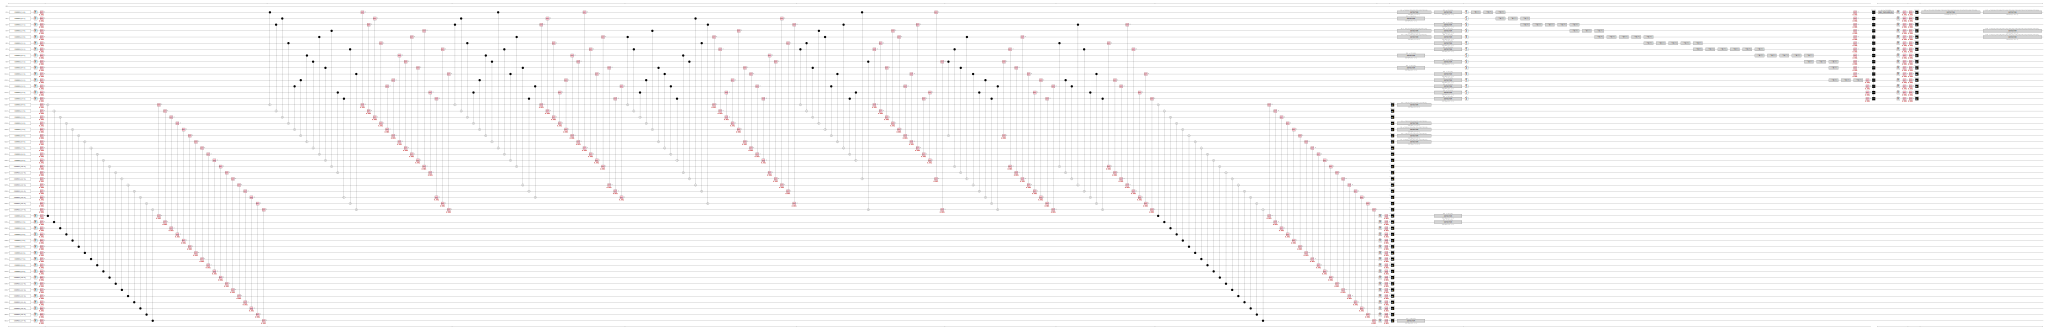

In [6]:
def qrm_circuit_S_gate(error_rate=0.01):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    for i in range(1, 16):
        circuit.append_operation("QUBIT_COORDS", [i], [qrm.get_bit(i,0) + 2 * qrm.get_bit(i,2), qrm.get_bit(i,1) + 2 * qrm.get_bit(i,3)])
    for j in range(16,34):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 16, 5])
    for j in range(34,52):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 34, 6])

    # initialize data qubits, ancilla qubits and flags
    circuit.append('H', list(range(1, 16)))
    circuit.append('H', list(range(34, 52)))
    circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
    circuit.append('TICK')

    # one round of stabilizer measurements
    for i in range(6):
        CNOT_list = []
        if i == 0:
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
        CNOT_list = []
        for j in range(18):
            qubit = qrm.QRM_Z_CHECKS[j][i]
            if qubit != 0:
                CNOT_list.extend([qubit, 16 + j])
        circuit.append('CNOT', CNOT_list)
        circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
        circuit.append('TICK')
        if i == 5:
            CNOT_list = []
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
            circuit.append('H', list(range(34,52)))
            circuit.append("DEPOLARIZE1", range(34,52), [error_rate])
            circuit.append('TICK')
    circuit.append('MR', list(range(16, 52)))


    # metachecks
    for i, mc in enumerate(qrm.QRM_META_CHECKS):
        mc = [c - 37 for c in mc]
        circuit.append('DETECTOR', [stim.target_rec(mc[0]),stim.target_rec(mc[1]),stim.target_rec(mc[2]),stim.target_rec(mc[3])], [i, 0, 0, 1])

    # check flags
    for j in range(18):
        circuit.append('DETECTOR', [stim.target_rec(-j-1)], [j // 4, j % 4, 1, 1]) 
    circuit.append('TICK')

    # apply transversal gates
    circuit.append('S', list(range(1, 16)))
    for i in range(15):
        for j in range(10):
            if C_full[i, j] == 1:
                #conditioned Z gate
                circuit.append('CZ', [stim.target_rec(j - 36), i + 1])
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    # final measurements
    logical_Y = [stim.target_y(i) for i in range(1, 16)]
    logical_Y = stim.target_combined_paulis(logical_Y)
    circuit.append('MPP', logical_Y)
    circuit.append('TICK')
    circuit.append('OBSERVABLE_INCLUDE', stim.target_rec(-1), 0)

    # final measurements
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    circuit.append('X_ERROR', list(range(1, 16)), [error_rate])
    circuit.append('MR', list(range(1, 16)))
    circuit.append('TICK')
    
    # readout checks
    for i, stabilizer in enumerate(qrm.QRM_X_CHECKS):
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer], [i, 0, 2, 1])

    
    # # readout logical X
    # circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)

    return circuit

circuit = qrm_circuit_S_gate(error_rate=0.001)
# circuit.without_noise().diagram('timeline-3d')
# circuit.without_noise().diagram('timeslice-svg')
circuit.diagram('timeline-svg')

In [7]:
circuit.diagram('matchgraph-3d')

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":1334,"max":[31.0011177062988,18.8201675415039,11.3452243804932],"min":[-8.78838348388672,-9.1535005569458,-5.34522485733032],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":1948,"max":[31.0011177062988,14.47829246521,11.3452243804932],"min":[-8.78838348388672,-9.1535005569458,-5.34522485733032],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":16008,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":23376,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":16008,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,5DiOP6uqqj4AAAAAOY6DQKuqqj4AAAAA5DiOP6uqqj4AAAAAOY6DQKuqqj4AAAAA5DiOP6uqqj4AAAAAOY6DQKuqqj4AAAAAHMdRQauqqj4AAEBA5DiOP6uqqj4AAMBA5DiOP6uqqj4AAAAAOY6DQKuqqj4AAAAAHMdRQauqqj4AAEB

In [8]:
import sinter
from typing import List

def post_selection_mask(noise):
    circuit = qrm_circuit_S_gate(noise)
    psmask = sinter.post_selection_mask_from_4th_coord(circuit)
    return psmask

tasks = [
    sinter.Task(
        circuit = qrm_circuit_S_gate(noise),
        postselection_mask = post_selection_mask(noise),
        json_metadata={'noise': noise}
    )
    for noise in [10**(x) for x in np.linspace(-3.5, -2, 10)]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=10,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000_000,
    max_errors=5000,
)

/var/folders/xh/4050w8c53s1g7wzh681w8sr40000gn/T/ipykernel_81252/1220677557.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


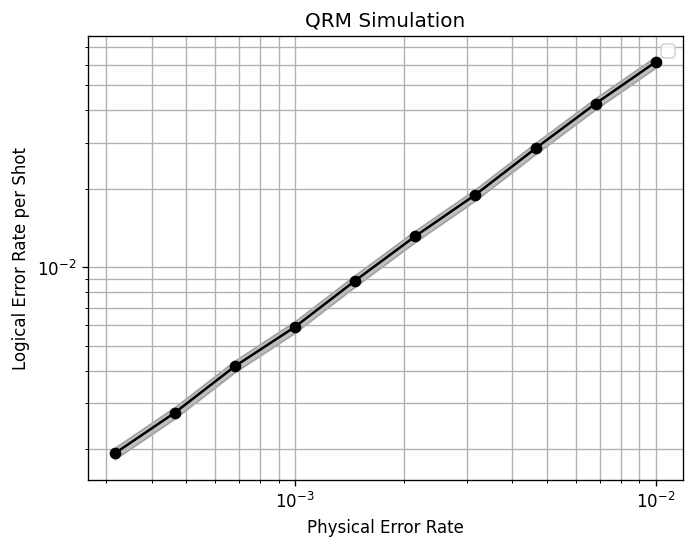

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['noise'],
)
# ax.set_ylim(1e-6, 5e-1)
# ax.set_xlim(5e-4, 1e-2)
ax.loglog()
ax.set_title("QRM Simulation")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

/var/folders/7j/yz8g10ld5n54t45czpzxpd180000gn/T/ipykernel_33165/3876593832.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


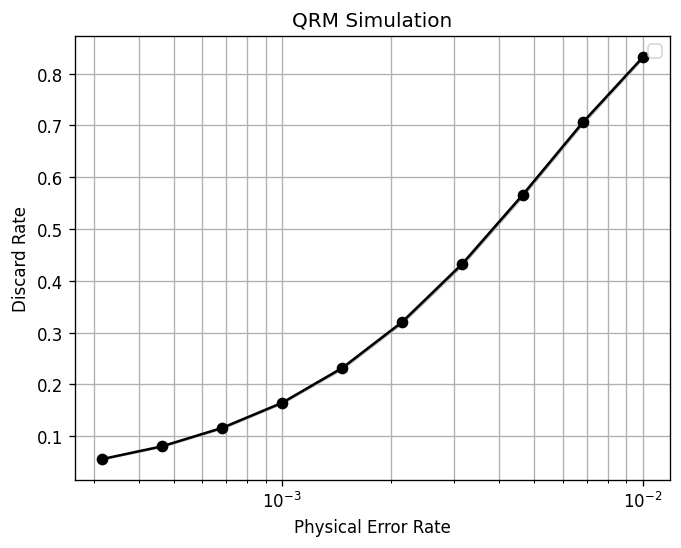

In [87]:
fig, ax = plt.subplots(1, 1)
sinter.plot_discard_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['noise'],
)
ax.set_title("QRM Simulation")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Discard Rate")
ax.set_xscale("log")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

# Test the correctness of feedback algorithm

We rotate the code to standard and apply transversal $S$.

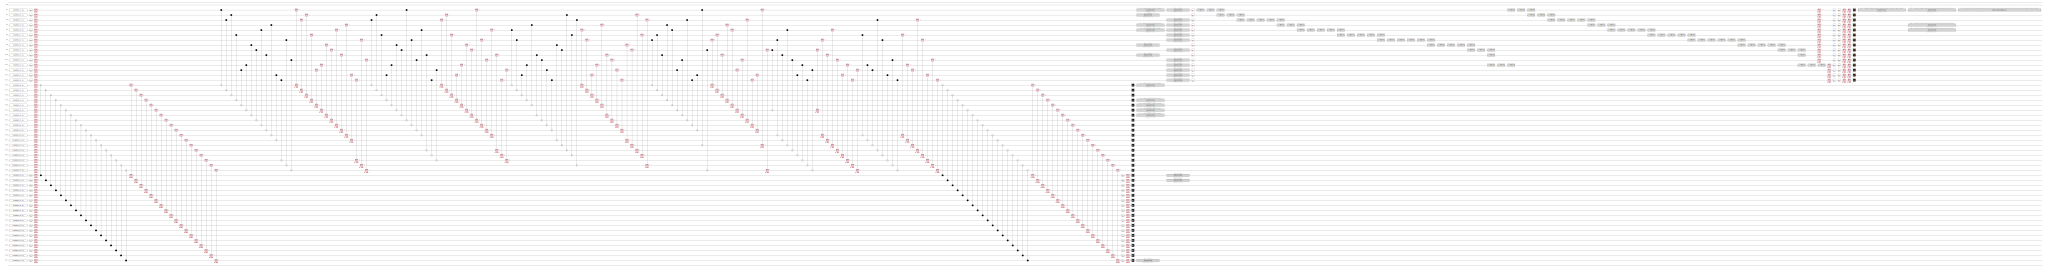

In [22]:
def qrm_circuit_S_gate(error_rate=0.01):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    for i in range(1, 16):
        circuit.append_operation("QUBIT_COORDS", [i], [qrm.get_bit(i,0) + 2 * qrm.get_bit(i,2), qrm.get_bit(i,1) + 2 * qrm.get_bit(i,3)])
    for j in range(16,34):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 16, 5])
    for j in range(34,52):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 34, 6])

    # initialize data qubits, ancilla qubits and flags
    circuit.append('H', list(range(1, 16)))
    circuit.append('H', list(range(34, 52)))
    circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
    circuit.append('TICK')

    # one round of stabilizer measurements
    for i in range(6):
        CNOT_list = []
        if i == 0:
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
        CNOT_list = []
        for j in range(18):
            qubit = qrm.QRM_Z_CHECKS[j][i]
            if qubit != 0:
                CNOT_list.extend([qubit, 16 + j])
        circuit.append('CNOT', CNOT_list)
        circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
        circuit.append('TICK')
        if i == 5:
            CNOT_list = []
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
            circuit.append('H', list(range(34,52)))
            circuit.append("DEPOLARIZE1", range(34,52), [error_rate])
            circuit.append('TICK')
    circuit.append('MR', list(range(16, 52)))


    # metachecks
    for i, mc in enumerate(qrm.QRM_META_CHECKS):
        mc = [c - 37 for c in mc]
        circuit.append('DETECTOR', [stim.target_rec(mc[0]),stim.target_rec(mc[1]),stim.target_rec(mc[2]),stim.target_rec(mc[3])], [i, 0, 0, 1])

    # check flags
    for j in range(18):
        circuit.append('DETECTOR', [stim.target_rec(-j-1)], [j // 4, j % 4, 1, 1]) 
    circuit.append('TICK')

    # apply transversal gates
    circuit.append('S', list(range(1, 16)))
    for i in range(15):
        for j in range(10):
            if C_full[i, j] == 1:
                #conditioned Z gate
                circuit.append('CZ', [stim.target_rec(j - 36), i + 1])
    for i in range(15):
        for j in range(10):
            if C_full[i, j] == 1:
                #conditioned Z gate
                circuit.append('CX', [stim.target_rec(j - 36), i + 1])
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    # final measurements
    # logical_Y = [stim.target_y(i) for i in range(1, 16)]
    # logical_Y = stim.target_combined_paulis(logical_Y)
    # circuit.append('MPP', logical_Y)
    # circuit.append('TICK')
    # circuit.append('OBSERVABLE_INCLUDE', stim.target_rec(-1), 0)

    # final measurements
    circuit.append('S', list(range(1, 16)))
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    circuit.append('X_ERROR', list(range(1, 16)), [error_rate])
    circuit.append('MR', list(range(1, 16)))
    circuit.append('TICK')
    
    # readout checks
    for i, stabilizer in enumerate(qrm.QRM_X_CHECKS):
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer], [i, 0, 2, 1])

    
    # # readout logical Y
    circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)

    return circuit


circuit = qrm_circuit_S_gate(error_rate=0.001)
# circuit.without_noise().diagram('timeline-3d')
# circuit.without_noise().diagram('timeslice-svg')
circuit.diagram('timeline-svg')


In [23]:
circuit.diagram('matchgraph-3d')

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":1978,"max":[31.0011177062988,18.8201675415039,6],"min":[-8.78838348388672,-9.1535005569458,-5.34522485733032],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":1036,"max":[13.1111106872559,9.33333396911621,11.3452243804932],"min":[-7.77889680862427,-7.68450403213501,3],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":23736,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":12432,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":23736,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,5DiOP6uqqj4AAAAAuez4wMWBXsBmjyLA5DiOP6uqqj4AAAAAOY6DQKuqqj4AAAAA5DiOP6uqqj4AAAAAOY6DQKuqqj4AAAAAOY7jQKuqqj4AAAAAHMchQauqqj4AAAAA5DiOP6uqqj4AAAAAOY6DQKuqqj4AAAAAOY7jQKuqqj4AAAAAHMchQauqqj4AAAAAjuOYQauqqj4

In [24]:
import sinter
from typing import List

def post_selection_mask(noise):
    circuit = qrm_circuit_S_gate(noise)
    psmask = sinter.post_selection_mask_from_4th_coord(circuit)
    return psmask

tasks = [
    sinter.Task(
        circuit = qrm_circuit_S_gate(noise),
        postselection_mask = post_selection_mask(noise),
        json_metadata={'noise': noise}
    )
    for noise in [10**(x) for x in np.linspace(-3.5, -2, 10)]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=10,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000_000,
    max_errors=5000,
)

/var/folders/xh/4050w8c53s1g7wzh681w8sr40000gn/T/ipykernel_81252/1220677557.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


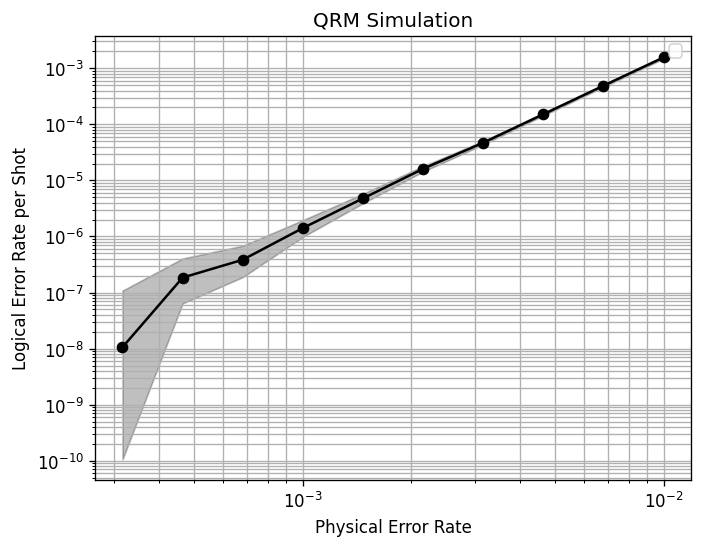

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['noise'],
)
# ax.set_ylim(1e-6, 5e-1)
# ax.set_xlim(5e-4, 1e-2)
ax.loglog()
ax.set_title("QRM Simulation")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

/var/folders/xh/4050w8c53s1g7wzh681w8sr40000gn/T/ipykernel_81252/3876593832.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


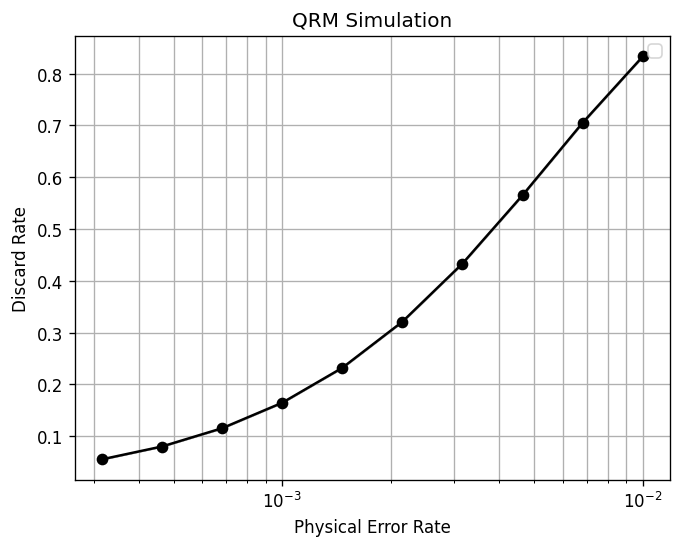

In [27]:
fig, ax = plt.subplots(1, 1)
sinter.plot_discard_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['noise'],
)
ax.set_title("QRM Simulation")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Discard Rate")
ax.set_xscale("log")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

# Check FT of feedback

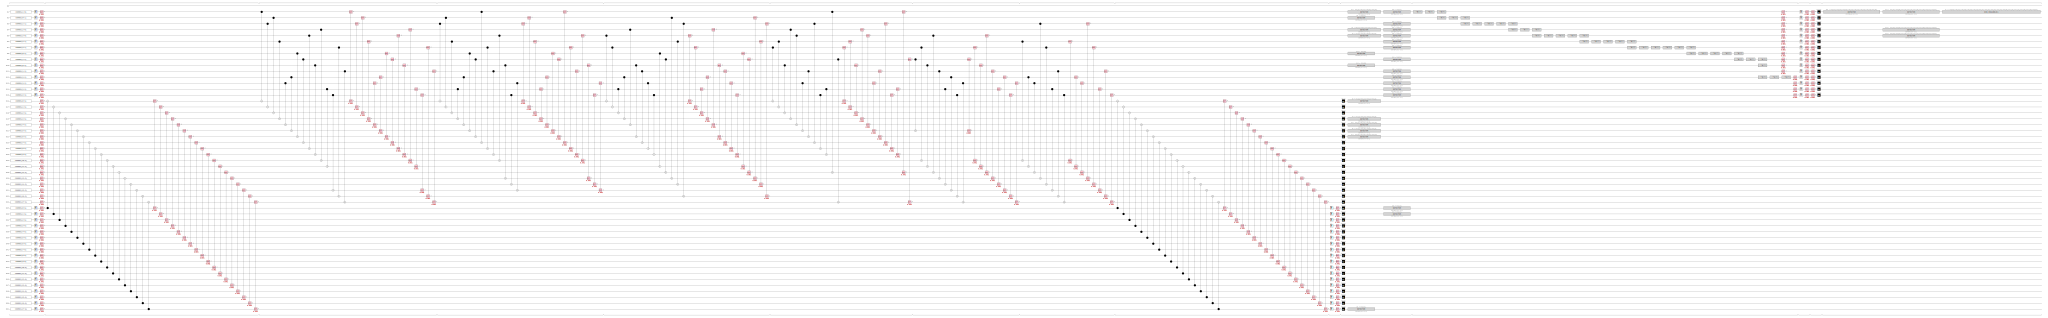

In [14]:
def qrm_circuit_S_gate(error_rate=0.01):
    """
    Returns a QRM circuit with depolarizing noise applied.
    The error rate can be adjusted.
    """
    circuit = stim.Circuit()
    for i in range(1, 16):
        circuit.append_operation("QUBIT_COORDS", [i], [qrm.get_bit(i,0) + 2 * qrm.get_bit(i,2), qrm.get_bit(i,1) + 2 * qrm.get_bit(i,3)])
    for j in range(16,34):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 16, 5])
    for j in range(34,52):
        circuit.append_operation("QUBIT_COORDS", [j], [j - 34, 6])

    # initialize data qubits, ancilla qubits and flags
    circuit.append('H', list(range(1, 16)))
    circuit.append('H', list(range(34, 52)))
    circuit.append("DEPOLARIZE1", range(1,52), [error_rate])
    circuit.append('TICK')

    # one round of stabilizer measurements
    for i in range(6):
        CNOT_list = []
        if i == 0:
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
        CNOT_list = []
        for j in range(18):
            qubit = qrm.QRM_Z_CHECKS[j][i]
            if qubit != 0:
                CNOT_list.extend([qubit, 16 + j])
        circuit.append('CNOT', CNOT_list)
        circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
        circuit.append('TICK')
        if i == 5:
            CNOT_list = []
            for j in range(18):
                CNOT_list.extend([34 + j, 16 + j])
            circuit.append('CNOT', CNOT_list)
            circuit.append("DEPOLARIZE2", CNOT_list, [error_rate])
            circuit.append('TICK')
            circuit.append('H', list(range(34,52)))
            circuit.append("DEPOLARIZE1", range(34,52), [error_rate])
            circuit.append('TICK')
    circuit.append('MR', list(range(16, 52)))


    # metachecks
    for i, mc in enumerate(qrm.QRM_META_CHECKS):
        mc = [c - 37 for c in mc]
        circuit.append('DETECTOR', [stim.target_rec(mc[0]),stim.target_rec(mc[1]),stim.target_rec(mc[2]),stim.target_rec(mc[3])], [i, 0, 0, 1])

    # check flags
    for j in range(18):
        circuit.append('DETECTOR', [stim.target_rec(-j-1)], [j // 4, j % 4, 1, 1]) 
    circuit.append('TICK')

    # apply transversal gates and introduct an ancilla qubit to record the parity
    for i in range(15):
        for j in range(10):
            if C_full[i, j] == 1:
                #conditioned Z gate
                circuit.append('CX', [stim.target_rec(j - 36), i + 1])
    # circuit.append('S', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    # final measurements
    circuit.append('H', list(range(1, 16)))
    circuit.append("DEPOLARIZE1", range(1,16), [error_rate])
    circuit.append('TICK')

    circuit.append('X_ERROR', list(range(1, 16)), [error_rate])
    circuit.append('MR', list(range(1, 16)))
    circuit.append('TICK')
    
    # readout checks
    for i, stabilizer in enumerate(qrm.QRM_X_CHECKS):
        circuit.append('DETECTOR', [stim.target_rec(i - 16) for i in stabilizer], [i, 0, 2, 1])

    # readout logical X
    circuit.append('OBSERVABLE_INCLUDE', [stim.target_rec(i - 15) for i in range(15)], 0)
    # # final measurements
    # logical_Y = []
    # Y_list = [1, 2, 3]
    # X_list = [4, 5, 6, 7]
    # logical_Y.extend([stim.target_y(i) for i in Y_list])
    # logical_Y.extend([stim.target_x(i) for i in X_list])
    # logical_Y = stim.target_combined_paulis(logical_Y)
    # circuit.append('MPP', logical_Y)
    # circuit.append('TICK')
    # circuit.append('OBSERVABLE_INCLUDE', stim.target_rec(-1), 0)

    return circuit

circuit = qrm_circuit_S_gate(error_rate=0.001)
# circuit.without_noise().diagram('timeline-3d')
# circuit.without_noise().diagram('timeslice-svg')
circuit.diagram('timeline-svg')


In [15]:
circuit.diagram('matchgraph-3d')

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":1978,"max":[31.0011177062988,18.8201675415039,6],"min":[-8.78838348388672,-9.1535005569458,-5.34522485733032],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":1036,"max":[13.1111106872559,9.33333396911621,11.3452243804932],"min":[-7.77889680862427,-7.68450403213501,3],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":6,"byteLength":23736,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":7,"byteLength":12432,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":23736,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,5DiOP6uqqj4AAAAAuez4wMWBXsBmjyLA5DiOP6uqqj4AAAAAOY6DQKuqqj4AAAAA5DiOP6uqqj4AAAAAOY6DQKuqqj4AAAAAOY7jQKuqqj4AAAAAHMchQauqqj4AAAAA5DiOP6uqqj4AAAAAOY6DQKuqqj4AAAAAOY7jQKuqqj4AAAAAHMchQauqqj4AAAAAjuOYQauqqj4

In [116]:
dem = circuit.detector_error_model()
with open("debug/dem_fb.txt", "w") as f:
    f.write(str(dem))
print("Wrote detector error model to debug/dem_fb.txt")

Wrote detector error model to debug/dem_fb.txt


In [16]:
import sinter
from typing import List

def post_selection_mask(noise):
    circuit = qrm_circuit_S_gate(noise)
    psmask = sinter.post_selection_mask_from_4th_coord(circuit)
    return psmask

tasks = [
    sinter.Task(
        circuit = qrm_circuit_S_gate(noise),
        postselection_mask = post_selection_mask(noise),
        json_metadata={'noise': noise}
    )
    for noise in [10**(x) for x in np.linspace(-3.5, -2, 10)]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=10,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000_000,
    max_errors=5000,
)

/var/folders/xh/4050w8c53s1g7wzh681w8sr40000gn/T/ipykernel_81252/1220677557.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


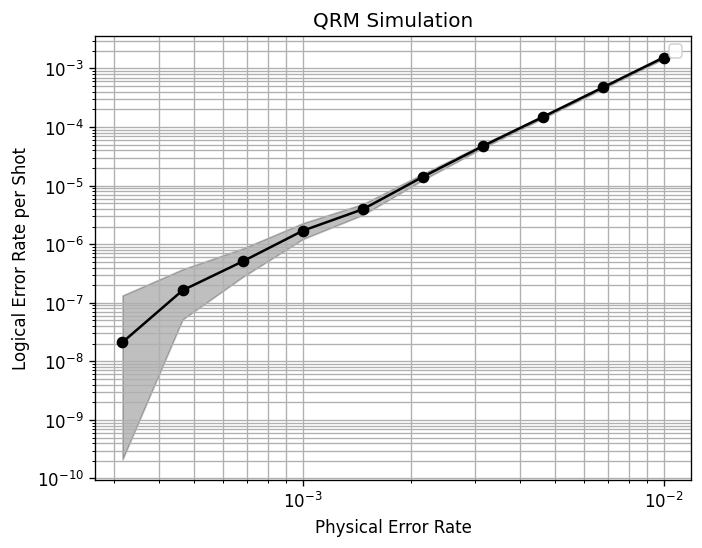

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['noise'],
)
# ax.set_ylim(1e-6, 5e-1)
# ax.set_xlim(5e-4, 1e-2)
ax.loglog()
ax.set_title("QRM Simulation")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

/var/folders/xh/4050w8c53s1g7wzh681w8sr40000gn/T/ipykernel_81252/3876593832.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


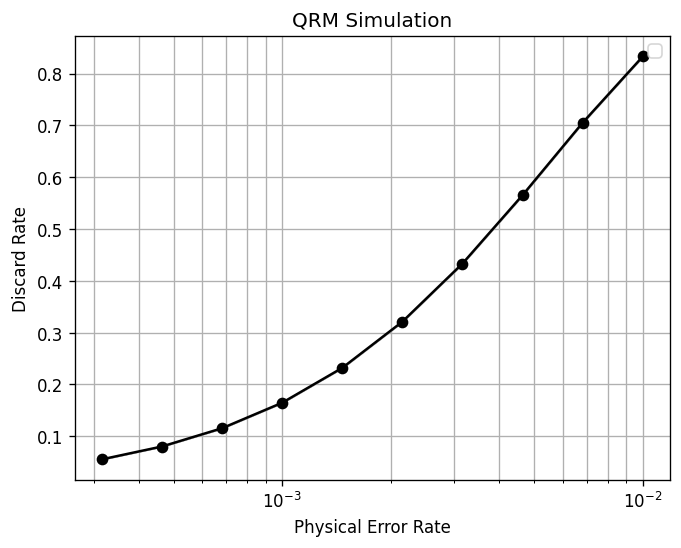

In [18]:
fig, ax = plt.subplots(1, 1)
sinter.plot_discard_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['noise'],
)
ax.set_title("QRM Simulation")
ax.set_xlabel("Physical Error Rate")
ax.set_ylabel("Discard Rate")
ax.set_xscale("log")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger